# Trees and Ensembles

In [73]:
# Global imports and settings
from preamble import *
%matplotlib inline
plt.rcParams['savefig.dpi'] = 120 # Use 300 for PDF, 100 for slides
# InteractiveShell.ast_node_interactivity = "all"
HTML('''<style>html, body{overflow-y: visible !important} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>''') # For slides

## Trees

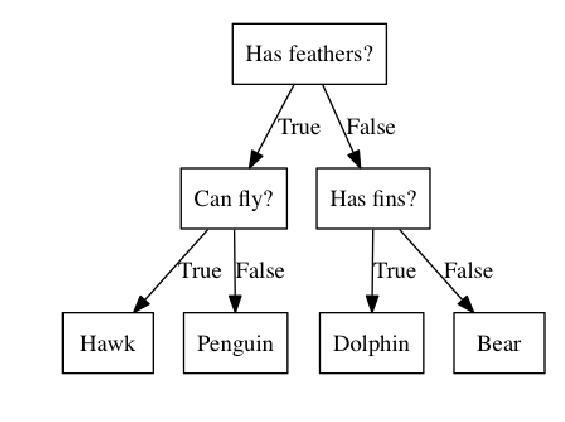

In [74]:
mglearn.plots.plot_animal_tree()

#### Building Decision Trees
* Split the data in two (or more) parts
* Search over all possible splits and choose the one that is most _informative_
    * Many heuristics
    * E.g. _information gain_: how much does the entropy of the class labels decrease after the split (purer 'leafs')
* Repeat recursive partitioning

Making predictions:
    
* Classification: find leaf for new data point, predict majority class (or class distribution)
* Regression: idem, but predict the _mean_ of all values    

#### Decision Tree classification

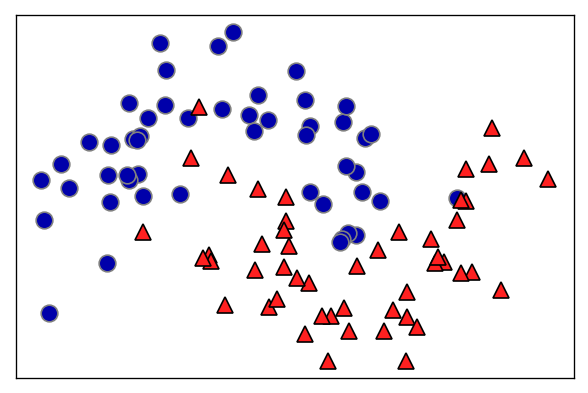

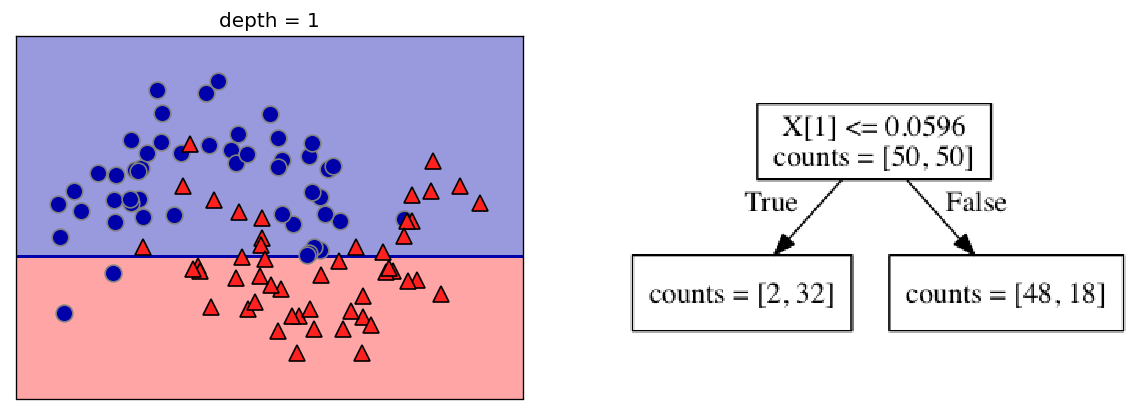

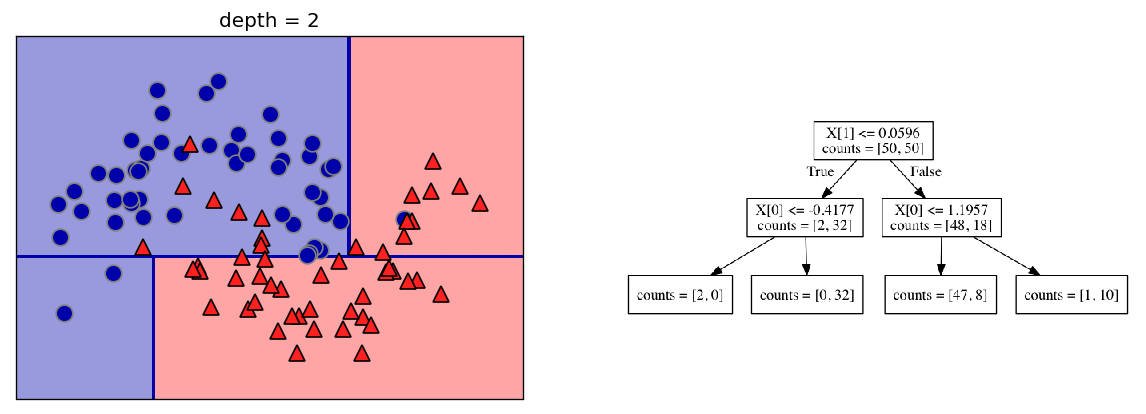

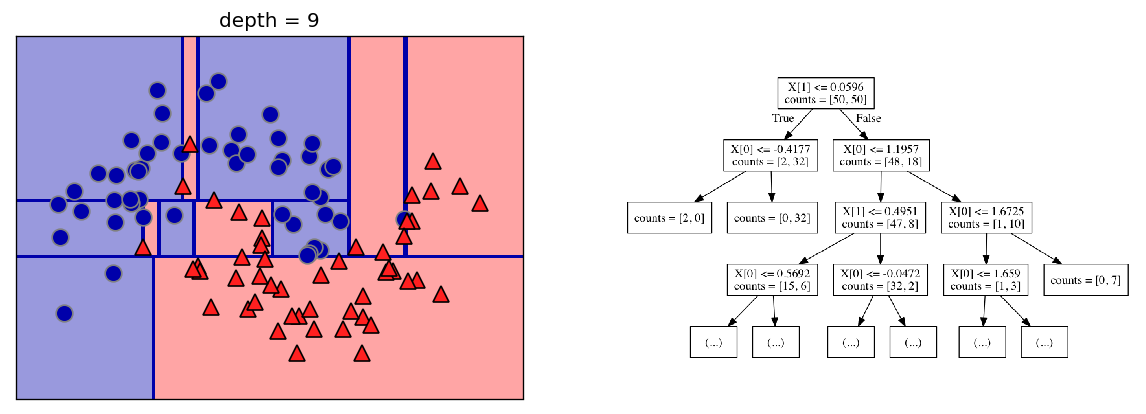

In [75]:
mglearn.plots.plot_tree_progressive()

### Heuristics

For classification ($X_i \rightarrow {class}_{k}$): *Impurity measures*:

- Misclassification Error (leads to larger trees):
$$ 1 - \underset{k}{\operatorname{argmax}} \hat{p}_{k} $$

- Gini-Index (probabilistic predictions):
$$ \sum_{k\neq k'} \hat{p}_k \hat{p}_{k'} = \sum_{k=1}^K \hat{p}_k(1-\hat{p}_k) $$

with $\hat{p}_k$ = the relative frequency of class $k$ in the leaf node

- Entropy (of the class attribute) measures *unpredictability* of the data:
    - How likely will random example have class k?
$$ E(X) = -\sum_{k=1}^K \hat{p}_k \log_{2}\hat{p}_k $$

- Information Gain (a.k.a. Kullback–Leibler divergence) for choosing attribute $X_i$ to split the data:
$$ G(X,X_i) = E(X) - \sum_{v=1}^V \frac{|X_{i=v}|}{|X_{i}|} E(X_{i=v}) $$

with $\hat{p}_k$ = the relative frequency of class $k$ in the leaf node,  $X$ = the training set, containing $i$ features (variables) $X_i$, $v$ a specific value for $X_i$, $X_{i=v}$ is the set of examples having value $v$ for feature $X_i$: $\{x \in X | X_i = v\}$

Heuristics visualized (binary class)
- Note that `gini != entropy/2`

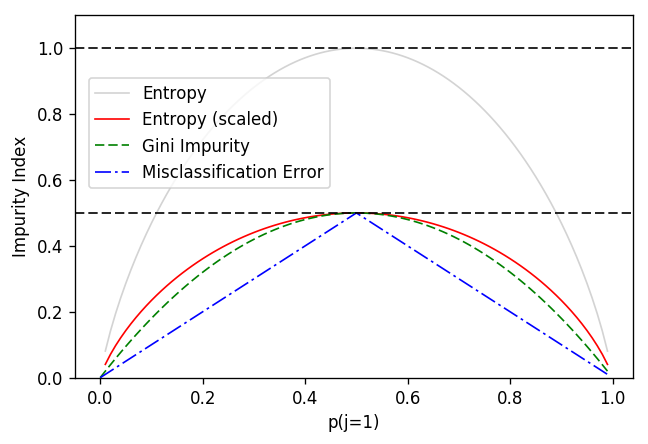

In [76]:
def gini(p):
   return (p)*(1 - (p)) + (1 - p)*(1 - (1-p))

def entropy(p):
   return - p*np.log2(p) - (1 - p)*np.log2((1 - p))

def classification_error(p):
   return 1 - np.max([p, 1 - p])

x = np.arange(0.0, 1.0, 0.01)
ent = [entropy(p) if p != 0 else None for p in x]
scaled_ent = [e*0.5 if e else None for e in ent]
c_err = [classification_error(i) for i in x]

fig = plt.figure()
ax = plt.subplot(111)

for j, lab, ls, c, in zip(
      [ent, scaled_ent, gini(x), c_err],
      ['Entropy', 'Entropy (scaled)', 'Gini Impurity', 'Misclassification Error'],
      ['-', '-', '--', '-.'],
      ['lightgray', 'red', 'green', 'blue']):
   line = ax.plot(x, j, label=lab, linestyle=ls, lw=1, color=c)

ax.legend(loc='upper left', bbox_to_anchor=(0.01, 0.85),
         ncol=1, fancybox=True, shadow=False)
ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')

plt.ylim([0, 1.1])
plt.xlabel('p(j=1)')
plt.ylabel('Impurity Index')
plt.show()

### Example

Ex.| 1 | 2 | 3 | 4 | 5 | 6
---|---|---|---|---|---|---
a1 | T | T | T | F | F | F
a2 | T | T | F | F | T | T
class | + | + | - | + | - | -

$E(X)$ ?  
$G(X, X_{a2})$ ?  
$G(X, X_{a1})$ ?

$E(X)$ = $-(\frac{1}{2}*log_2(\frac{1}{2})+\frac{1}{2}*log_2(\frac{1}{2})) = 1$ (classes have equal probabilities)    
$G(X, X_{a2})$ = 0 (after split, classes still have equal probabilities, entropy stays 1)

Ex.| 1 | 2 | 3 | 4 | 5 | 6
---|---|---|---|---|---|---
a1 | T | T | T | F | F | F
a2 | T | T | F | F | T | T
class | + | + | - | + | - | -

$$ E(X) = -\sum_{k=1}^K \hat{p}_k \log\hat{p}_k \quad , \quad G(X,X_i) = E(X) - \sum_{v=1}^V \frac{|X_{i=v}|}{|X_{i}|} E(X_{i=v}) $$

$$E(X_{a1=T}) = - \frac{2}{3} \log_{2}(\frac{2}{3}) - \frac{1}{3} \log_{2}(\frac{1}{3}) = 0.9183 \quad (= E(X_{a1=F}))$$
$$G(X, X_{a1}) = 1 - \frac{1}{2} 0.9183 - \frac{1}{2} 0.9183 = 0.0817 $$

hence we split on a1

#### Heuristics in scikit-learn

The splitting criterion can be set with the `criterion` option in `DecisionTreeClassifier`

- `gini` (default): gini impurity index
- `entropy`: information gain

Best value depends on dataset, as well as other hyperparameters

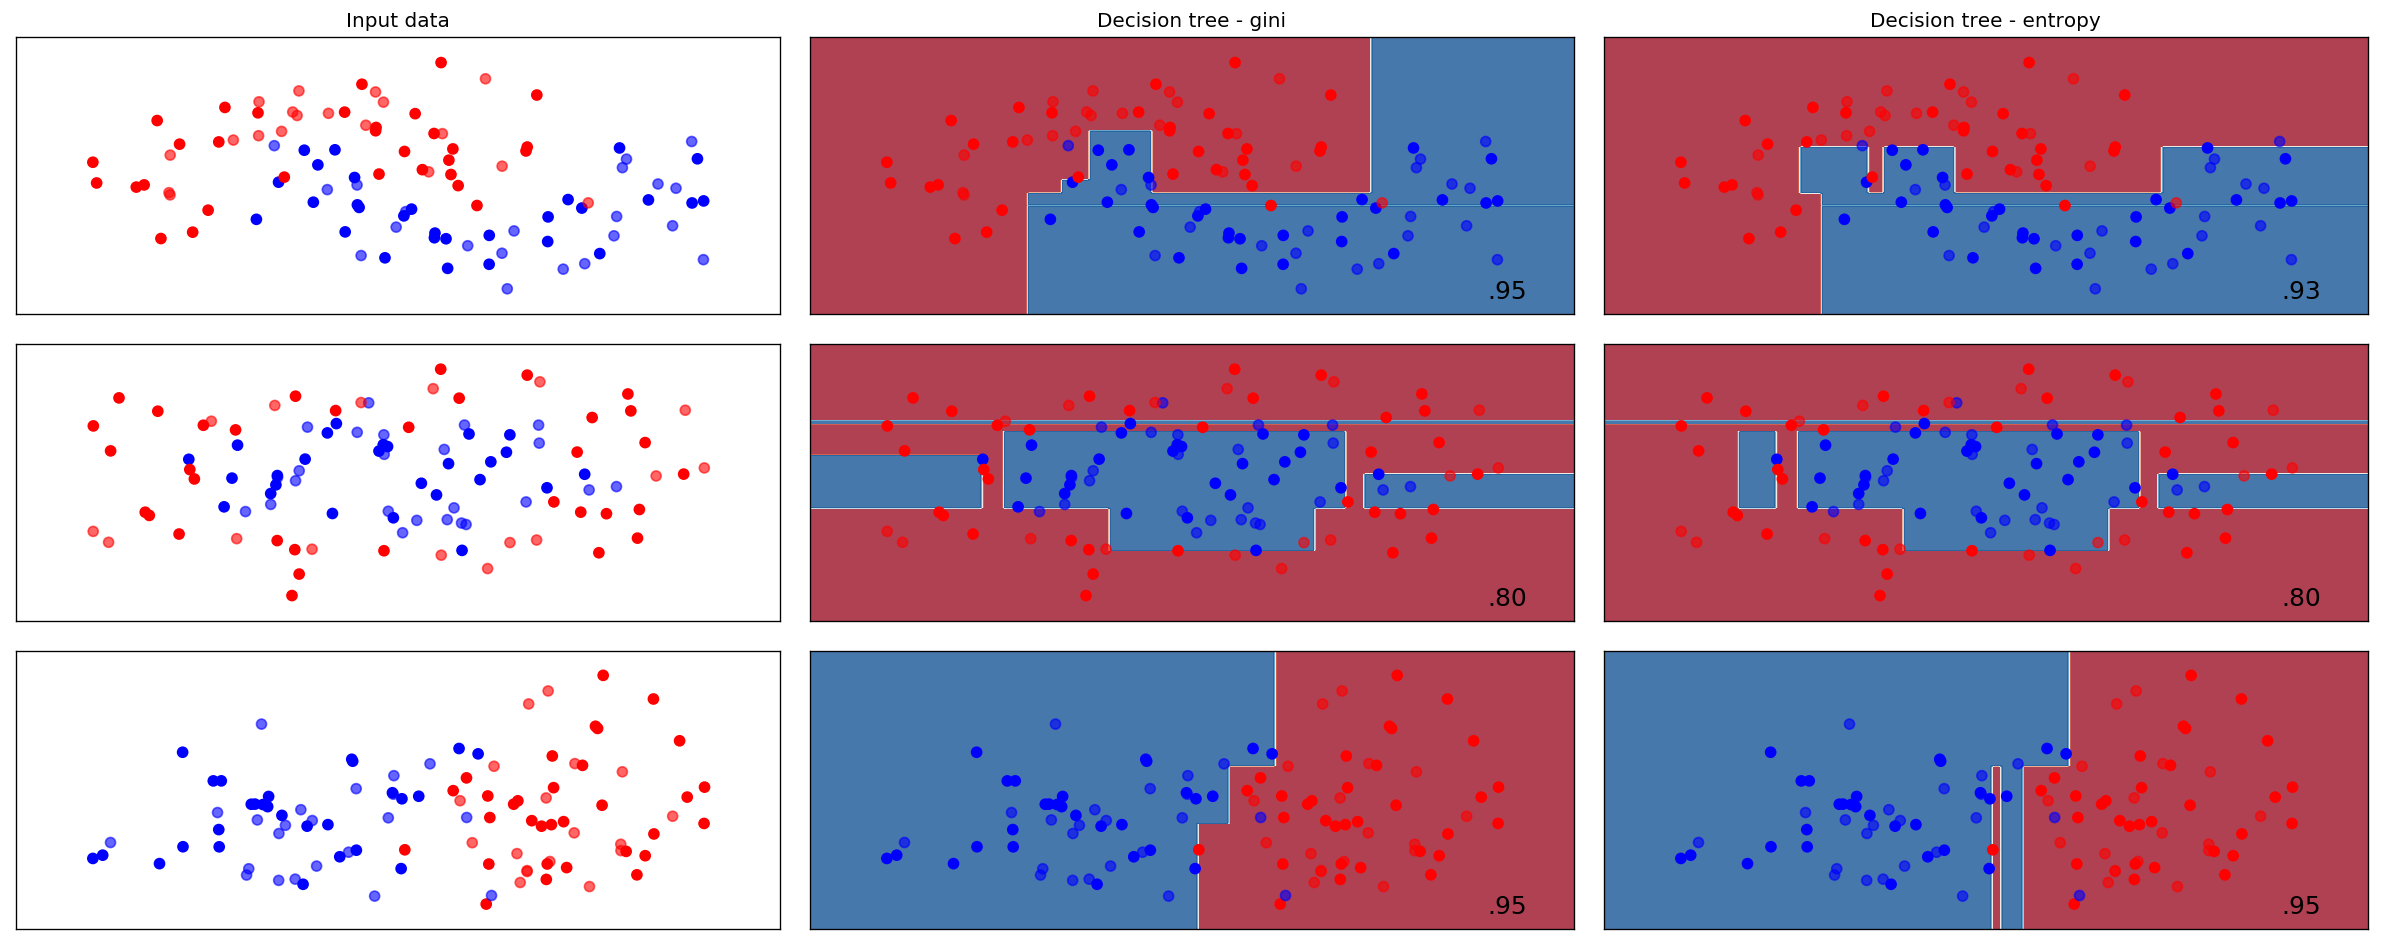

In [77]:
import plot_classifiers as pc
names = ["Decision tree - gini", "Decision tree - entropy"]

classifiers = [
    DecisionTreeClassifier(),
    DecisionTreeClassifier(criterion="entropy")
    ]

pc.plot_classifiers(names, classifiers, figuresize=(20,8))

### Handling many-valued features
What happens when a feature has (almost) as many values as examples?
- Information Gain will select it

One approach: use Gain Ratio instead (not available scikit-learn):
$$ GainRatio(X,X_i) = \frac{Gain(X,X_i)}{SplitInfo(X,X_i)}$$  
$$ SplitInfo(X,X_i) = - \sum_{v=1}^V \frac{|X_{i=v}|}{|X|} log_{2} \frac{|X_{i=v}|}{|X|} $$

where $X_{i=v}$ is the subset of examples for which feature $X_i$ has value v.

SplitInfo will be big if $X_i$ fragments the data into many small subsets, resulting in a smaller Gain Ratio. 

### Overfitting: Controlling complexity of Decision Trees
Decision trees can very easily overfit the data. Regularization strategies:  

* Pre-pruning: stop creation of new leafs at some point
    * Limiting the depth of the tree, or the number of leafs
    * Requiring a minimal leaf size (number of instances)
* Post-pruning: build full tree, then prune (join) leafs
    * Reduced error pruning: evaluate against held-out data
    * Many other strategies exist. 
    * scikit-learn supports none of them (yet)

Effect of pre-pruning: default tree overfits, setting `max_depth=4` is better

In [78]:
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, stratify=cancer.target, random_state=42)
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.937


In [79]:
tree = DecisionTreeClassifier(max_depth=4, random_state=0)
tree.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 0.988
Accuracy on test set: 0.951


Analyzing Decision Trees manually

- Visualize and find the path that most data takes

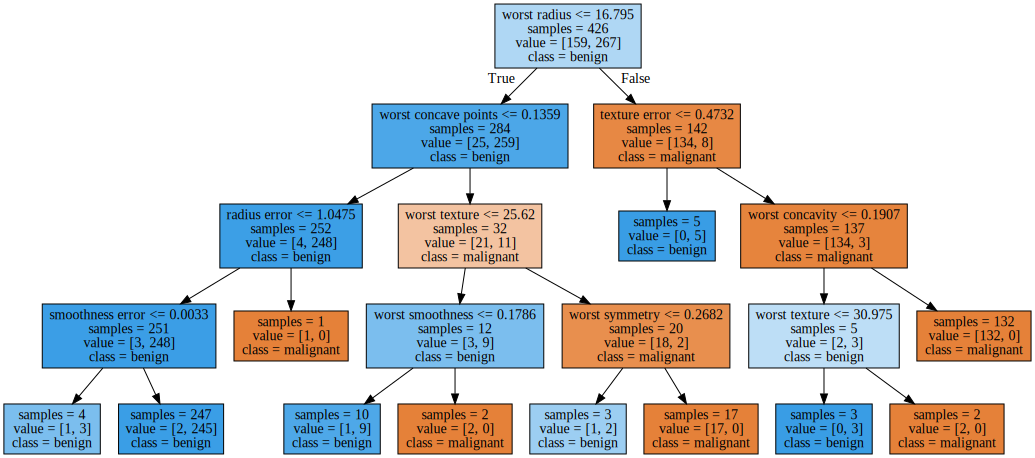

In [80]:
# Creates a .dot file
from sklearn.tree import export_graphviz
export_graphviz(tree, out_file="tree.dot", class_names=["malignant", "benign"], 
                feature_names=cancer.feature_names, impurity=False, filled=True)
# Open and display
import graphviz
with open("tree.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

`DecisionTreeClassifier` also returns _feature importances_

* In [0,1], sum up to 1
* High values for features selected by the algorithm
* Other features may also be relevant, but don't contribute new information given the selected features

In [81]:
# Feature importances sum up to 1
print("Feature importances:\n{}".format(tree.feature_importances_))

Feature importances:
[ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.01
  0.048  0.     0.     0.002  0.     0.     0.     0.     0.     0.727
  0.046  0.     0.     0.014  0.     0.018  0.122  0.012  0.   ]


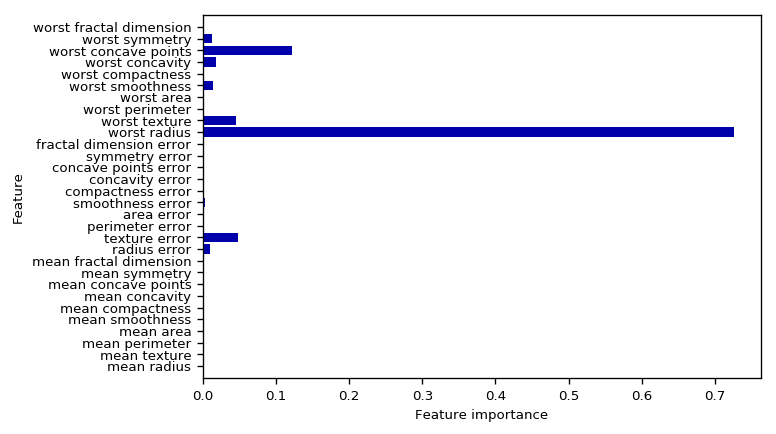

In [82]:
def plot_feature_importances_cancer(model):
    n_features = cancer.data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plt.rcParams.update({'font.size': 8})
plot_feature_importances_cancer(tree)

### Decision tree regression
Heuristic for regression ($x_i \rightarrow y_i \in {\rm I\!R}$): *Minimal quadratic distance*

- Consider splits at every data point for every variable (or halfway between data points)
- Dividing the data on split variable $X_j$ at splitpoint $s$ leads to the following half-spaces:

$$ R_1(j, s) = { X : X_j \leq s} \quad and \quad R_2(j, s) = { X : X_j > s} $$
    
- The best split variable and the corresponding splitpoint, with predicted value $c_i$ and actual value $Y_i$:

$$ \min_{j,s} \left(\min_{c_1} \sum_{x_{i} \in R_1(j,s)} (y_i - c_1)^2 + \min_{c_2} \sum_{x_{i} \in R_2(j,s)} (y_i - c_2)^2 \right) $$

- Assuming that the tree predicts $y_i$ as the average of all $x_i$ in the leaf:
    
$$ \hat{c}_1 = \text{avg}(y_i | x_{i} \in R_1(j,s)) \quad and \quad \hat{c}_2 = \text{avg}(y_i | x_{i} \in R_2(j,s)) $$

with $x_i$ being the i-th example in the data, with target value $y_i$

#### In scikit-learn
Regression is done with  `DecisionTreeRegressor`

In [83]:
def plot_decision_tree_regression(regr_1, regr_2):
    # Create a random dataset
    rng = np.random.RandomState(1)
    X = np.sort(5 * rng.rand(80, 1), axis=0)
    y = np.sin(X).ravel()
    y[::5] += 3 * (0.5 - rng.rand(16))

    # Fit regression model
    regr_1.fit(X, y)
    regr_2.fit(X, y)

    # Predict
    X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
    y_1 = regr_1.predict(X_test)
    y_2 = regr_2.predict(X_test)

    # Plot the results
    plt.figure(figsize=(8,6))
    plt.scatter(X, y, c="darkorange", label="data")
    plt.plot(X_test, y_1, color="cornflowerblue", label="max_depth=2", linewidth=2)
    plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=5", linewidth=2)
    plt.xlabel("data")
    plt.ylabel("target")
    plt.title("Decision Tree Regression")
    plt.legend()
    plt.show()

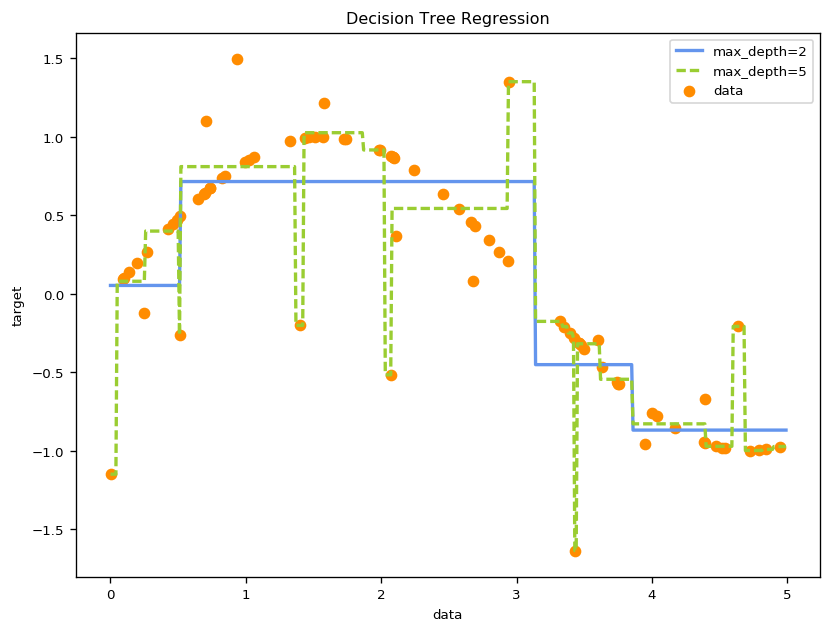

In [84]:
from sklearn.tree import DecisionTreeRegressor
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)

plot_decision_tree_regression(regr_1,regr_2)

Note that decision trees do not extrapolate well. 

- The leafs return the same _mean_ value no matter how far the new data point lies from the training examples.
- Example on the `ram_price` forecasting dataset

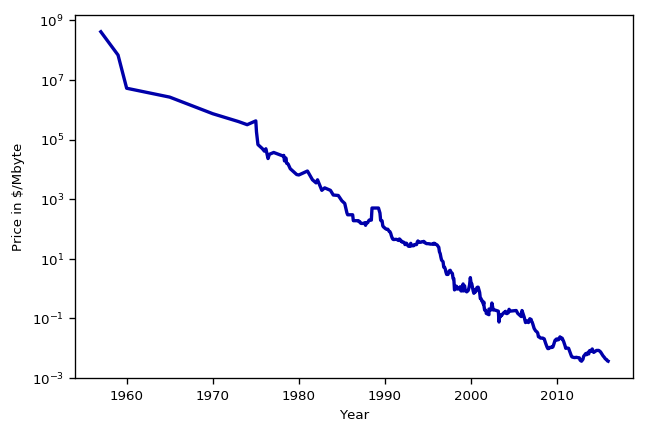

In [85]:
ram_prices = pd.read_csv('data/ram_price.csv')

plt.semilogy(ram_prices.date, ram_prices.price)
plt.xlabel("Year")
plt.ylabel("Price in $/Mbyte");

In [86]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

# Use historical data to forecast prices after the year 2000
data_train = ram_prices[ram_prices.date < 2000]
data_test = ram_prices[ram_prices.date >= 2000]

# predict prices based on date:
X_train = data_train.date[:, np.newaxis]
# we use a log-transform to get a simpler relationship of data to target
y_train = np.log(data_train.price)

tree = DecisionTreeRegressor().fit(X_train, y_train)
linear_reg = LinearRegression().fit(X_train, y_train)

# predict on all data
X_all = ram_prices.date[:, np.newaxis]

pred_tree = tree.predict(X_all)
pred_lr = linear_reg.predict(X_all)

# undo log-transform
price_tree = np.exp(pred_tree)
price_lr = np.exp(pred_lr)

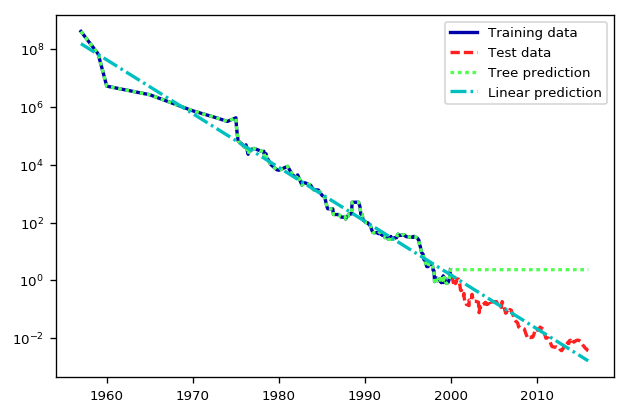

In [87]:
plt.rcParams['lines.linewidth'] = 2
plt.semilogy(data_train.date, data_train.price, label="Training data")
plt.semilogy(data_test.date, data_test.price, label="Test data")
plt.semilogy(ram_prices.date, price_tree, label="Tree prediction")
plt.semilogy(ram_prices.date, price_lr, label="Linear prediction")
plt.legend();

#### Strengths, weaknesses and parameters
Pre-pruning: regularize by:

* Setting a low `max_depth`, `max_leaf_nodes`
* Setting a higher `min_samples_leaf` (default=1)

Decision trees: 

* Work well with features on completely different scales, or a mix of binary and continuous features
    * Does not require normalization
* Interpretable, easily visualized
* Still tend to overfit easily. Use ensembles of trees.

## Ensemble learning
Ensembles are methods that combine multiple machine learning models to create more powerful models. Most popular are:

* __RandomForests__: Build randomized trees on random samples of the data
* __Gradient boosting machines__: Build trees iteratively, giving higher weights to the points misclassified by previous trees

In both cases, predictions are made by doing a vote over the members of the example.  
__Stacking__ is another technique that builds a (meta)model over the predictions of each member.

### RandomForests
Reduce overfitting by averaging out individual predictions (variance reduction)

* Take a _bootstrap sample_ of your data
    * Randomly sample with replacement
    * Build a tree on each bootstrap
* Repeat `n_estimators` times 
    * Higher values: more trees, more smoothing
    * Make prediction by aggrating the individual tree predictions
        * a.k.a. Bootstrap aggregating (Bagging)
* RandomForest: Randomize trees by considering only a random subset of features of size `max_features` _in each node_
    * Small `max_features` yields more different trees, more smoothing
    * Default: $sqrt(n\_features)$ for classification, $log2(n\_features)$ for regression


Making predictions:
* Classification: soft voting
    * Every member returns probability for each class
    * After averaging, the class with highest probability wins
* Regression:  
    * Return the _mean_ of all predictions

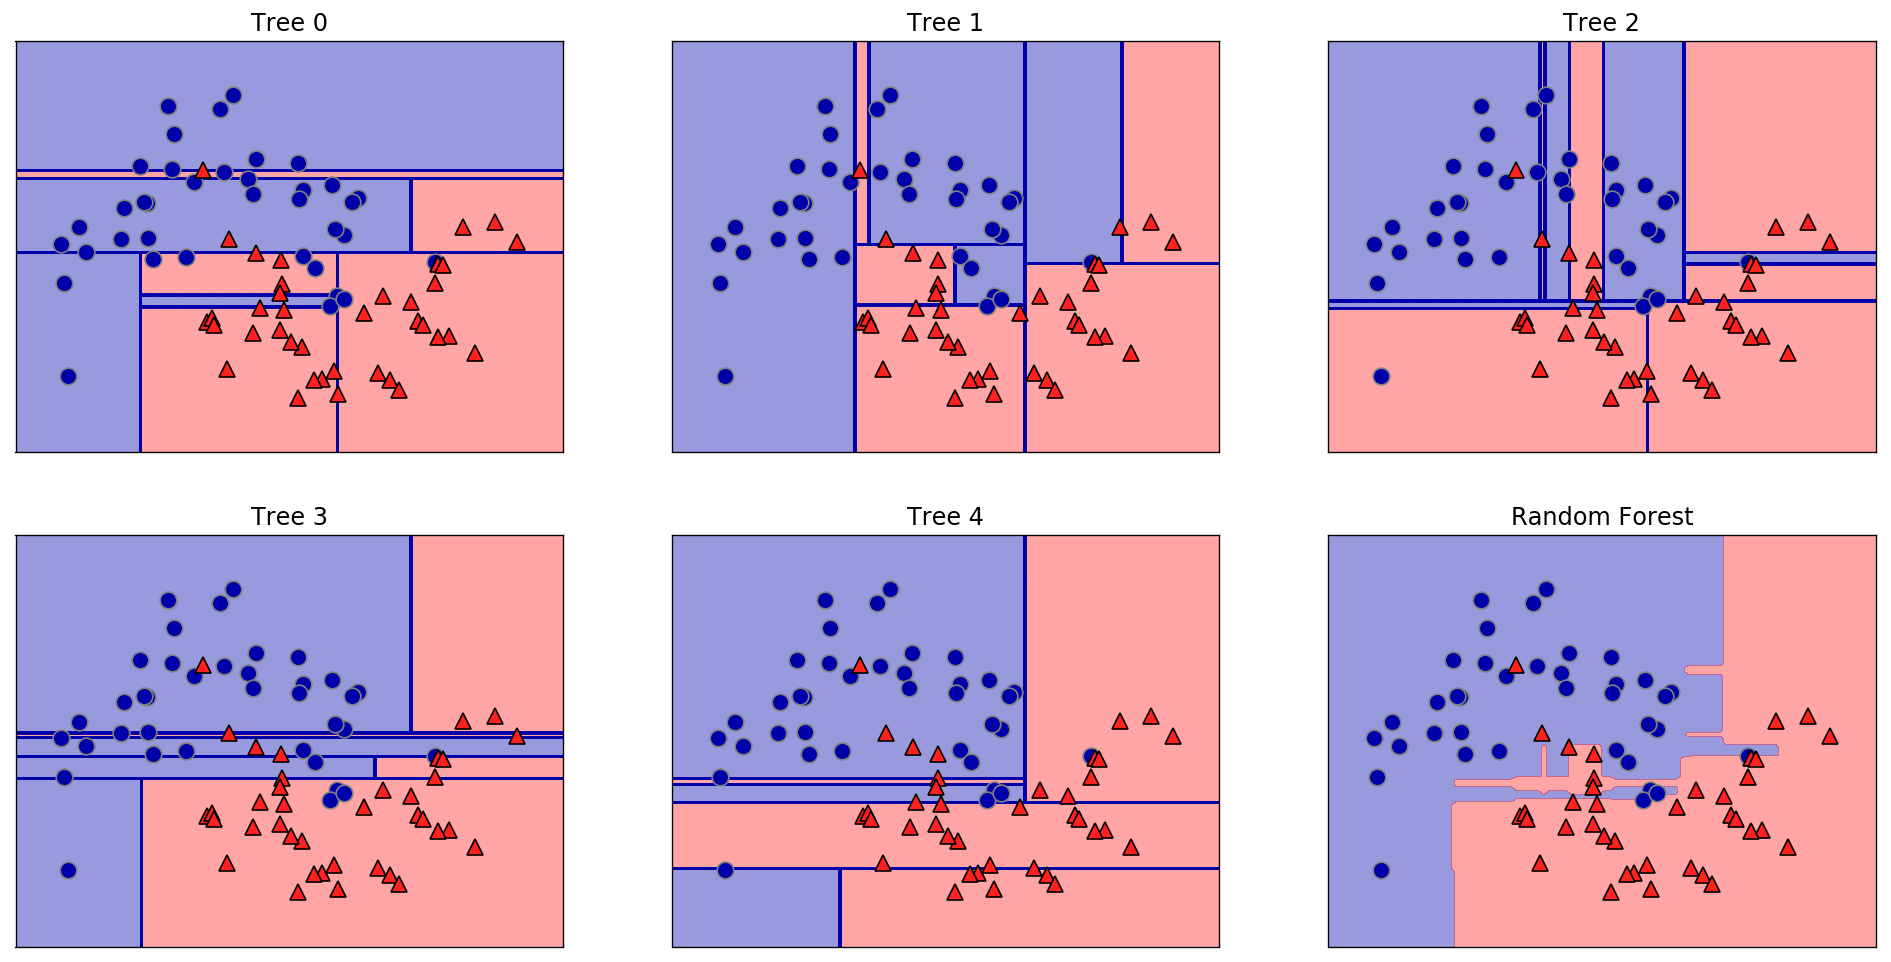

In [101]:
from sklearn.ensemble import RandomForestClassifier  
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, noise=0.25, random_state=3)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                    random_state=42)

forest = RandomForestClassifier(n_estimators=5, random_state=2)
forest.fit(X_train, y_train) 

plt.rcParams.update({'font.size': 12})
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, (ax, tree) in enumerate(zip(axes.ravel(), forest.estimators_)):
    ax.set_title("Tree {}".format(i))
    mglearn.plots.plot_tree_partition(X_train, y_train, tree, ax=ax)
    
mglearn.plots.plot_2d_separator(forest, X_train, fill=True, ax=axes[-1, -1],
                                alpha=.4)
axes[-1, -1].set_title("Random Forest")
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train);

Scikit-learn algorithms:

- `RandomForestClassifier` (or Regressor)
- `ExtraTreesClassifier`: Grows deeper trees, faster

Most important parameters:

* `n_estimators` (higher is better, but diminishing returns)
* `max_features` (default is typically ok)
    * Set smaller to reduce space/time requirements
* parameters of trees, e.g. `max_depth` (less effect)

`n_jobs` sets the number of parallel cores to run  
`random_state` should be fixed for reproducibility

In [108]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)
forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [112]:
forest = RandomForestClassifier(n_estimators=10, random_state=0) # Vary n_estimators
forest.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.951


RandomForest allow another way to evaluate performance: out-of-bag (OOB) error

- While growing forest, estimate test error from training samples
- For each tree grown, 33-36% of samples are not selected in bootstrap
    - Called the 'out of bootstrap' (OOB) samples
    - Predictions are made as if they were novel test samples
    - Through book-keeping, majority vote is computed for all OOB samples from all trees
- OOB estimated test error is rather accurate in practice
    - As good as CV estimates, but can be computed on the fly (without repeated model fitting)
    - Tend to be slightly pessimistic

In scikit-learn OOB error are returned as follows:
```
oob_error = 1 - clf.oob_score_
```

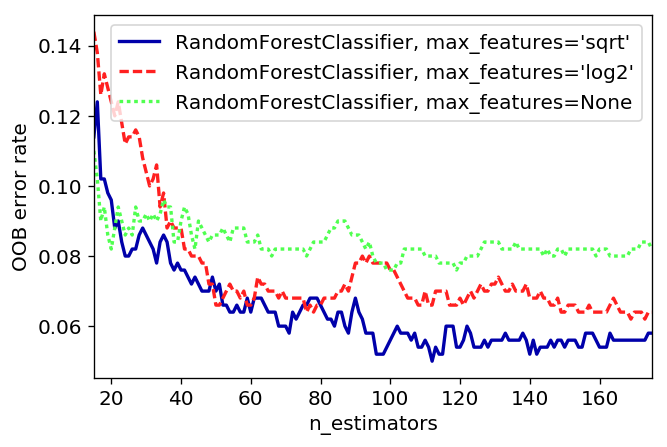

In [142]:
from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

RANDOM_STATE = 123

# Generate a binary classification dataset.
X, y = make_classification(n_samples=500, n_features=25,
                           n_clusters_per_class=1, n_informative=15,
                           random_state=RANDOM_STATE)

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 175

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

#### Feature importance
RandomForests provide more reliable feature importances, based on many alternative hypotheses (trees)

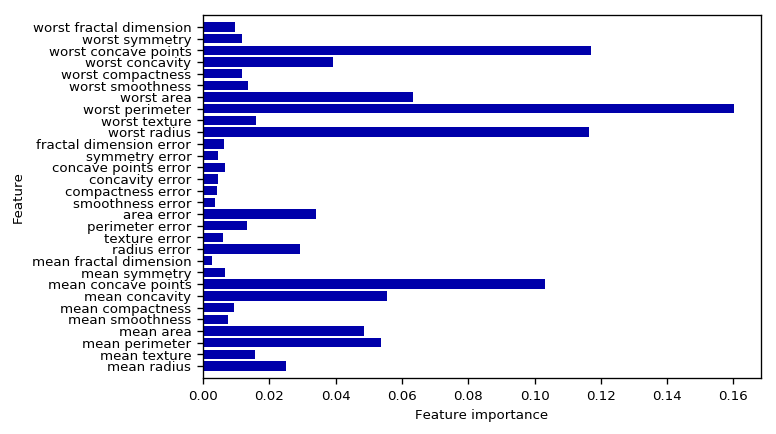

In [98]:
plt.rcParams.update({'font.size':8})
plot_feature_importances_cancer(forest)

#### Strengths, weaknesses and parameters
RandomForest are among most widely used algorithms:

* Don't require a lot of tuning
* Typically very accurate models
* Handles heterogeneous features well
* Implictly selects most relevant features

Downsides:

* less interpretable, slower to train (but parallellizable)
* don't work well on high dimensional sparse data (e.g. text)

## Gradient Boosted Regression Trees (Gradient Boosting Machines)
Instead of reducing the variance of overfitted models, reduce the bias of underfitted models

* Use strong pre-pruning to build very shallow trees
    * Default `max_depth`=3
* Iteratively build new trees by increasing weights of points that were badly predicted
    * `learning rate` controls how strongly the weights are altered in each iteration (default 0.1)
    * Gradient descent (covered later) finds optimal set of weights
* Repeat `n_estimators` times (default 100)

Example:
![boosting](./images/04_boosting_0.png)

After 1 iteration

- The simple decision tree divides space
- Misclassified points get higher weight (larger dots)

![boosting](./images/04_boosting_1.png)

After 3 iterations

![boosting](./images/04_boosting_3.png)

After 20 iterations

![boosting](./images/04_boosting_20.png)

Each tree provides good predictions on part of the data, use voting for final prediction

* Soft voting for classification, mean values for regression

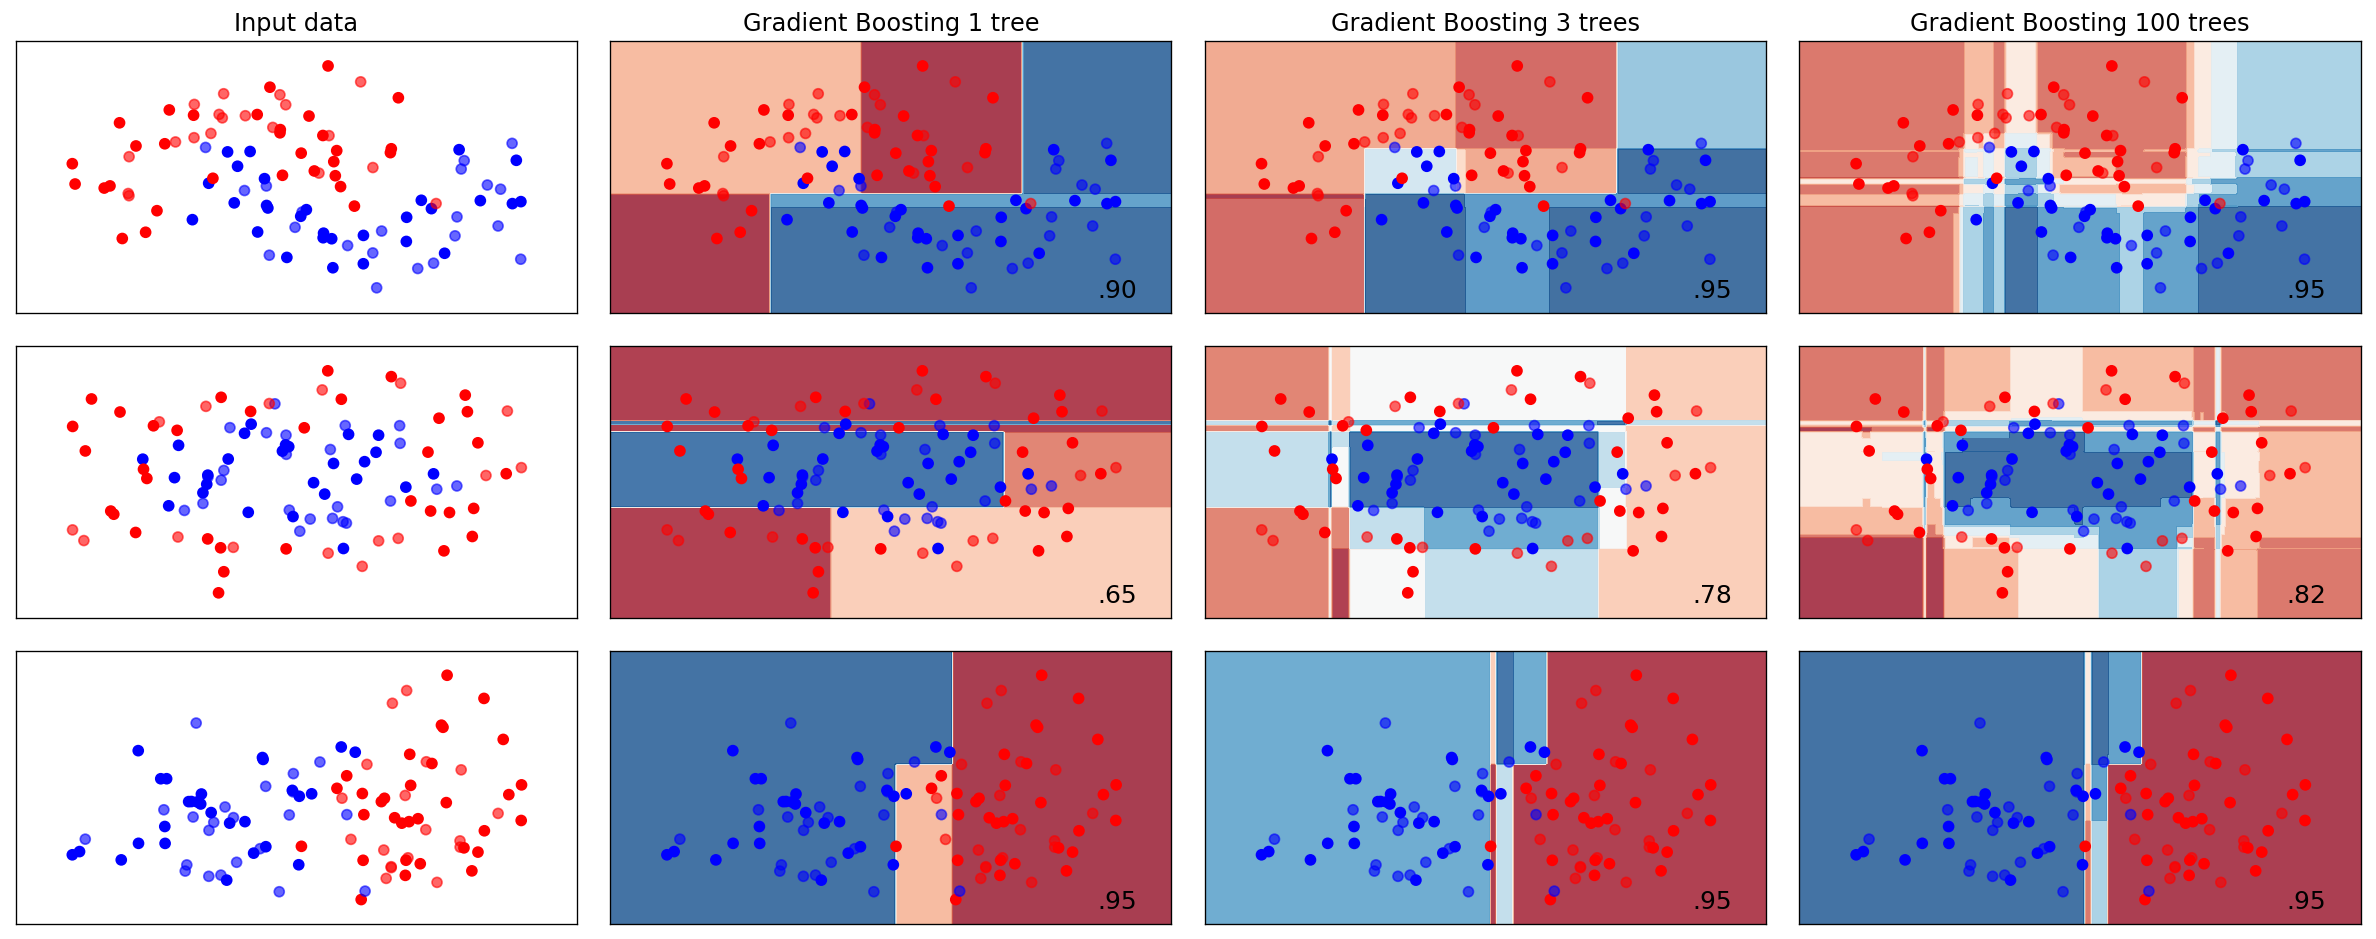

In [136]:
import plot_classifiers as pc
names = ["Gradient Boosting 1 tree", "Gradient Boosting 3 trees", "Gradient Boosting 100 trees"]

classifiers = [
    GradientBoostingClassifier(n_estimators=1, random_state=0, learning_rate=0.5),
    GradientBoostingClassifier(n_estimators=3, random_state=0, learning_rate=0.5),
    GradientBoostingClassifier(n_estimators=100, random_state=0, learning_rate=0.5)
    ]

pc.plot_classifiers(names, classifiers, figuresize=(20,8))

### Tuning 
- n_estimators: Higher is better, but will start to overfit
- learning_rate: Lower rates mean more trees are needed to get more complex models
    - Main regularizer, also known as 'shrinkage'
    - Set n_estimators as high as possible, then tune learning_rate
- max_depth: typically kept low (<5), reduce when overfitting
- loss: Loss function used for gradient descent (defaults OK)
    - Classification:
        - `deviance` (default): log-likelihood loss (as in logistic regression)
        - `exponential`: exponential loss (AdaBoost algorithm)
    - Regression:
        - `ls`: Least squares (typically the best option)

In [93]:
from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.958


In [94]:
# We are overfitting. We can decrease max_depth
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 0.991
Accuracy on test set: 0.972


In [95]:
# or decrease the learning rate (less effect)
gbrt = GradientBoostingClassifier(random_state=0, learning_rate=0.01)
gbrt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 0.988
Accuracy on test set: 0.965


Gradient boosting machines use much simpler trees
- Hence, tends to completely ignore some of the features

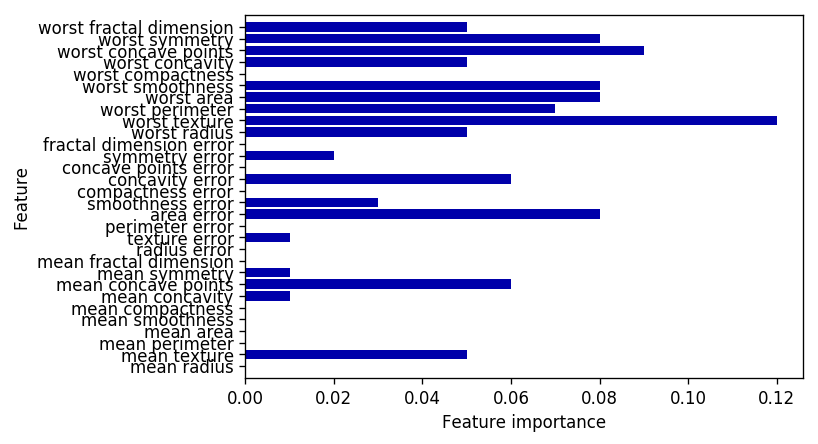

In [96]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)

plot_feature_importances_cancer(gbrt)

##### Strengths, weaknesses and parameters
* Among the most powerful and widely used models
* Work well on heterogeneous features and different scales
* Require careful tuning, take longer to train.
* Does not work well on high-dimensional sparse data

Main hyperparameters:

* `n_estimators`: Higher is better, but will start to overfit
* `learning_rate`: Lower rates mean more trees are needed to get more complex models
    * Set `n_estimators` as high as possible, then tune `learning_rate`
* `max_depth`: typically kept low (<5), reduce when overfitting

### XGBoost

XGBoost is another python library for gradient boosting (install separately). 

- The main difference lies the use of approximation techniques to make it faster.
    - Hence, you can do 10x (or 100x) more boosting iterations in same amount of time
- Sketching: Given 10000 possible splits, it will only consider 300 "good enough" splits by default
    - Controlled by the `sketch_eps` parameter (default 0.03)
- Loss function approximation with Taylor Expansion: more efficient way to evaluate splits

Further reading:
[XGBoost Documentation](https://xgboost.readthedocs.io/en/latest/parameter.html#parameters-for-tree-booster)
[Paper](http://arxiv.org/abs/1603.02754)


Comparison

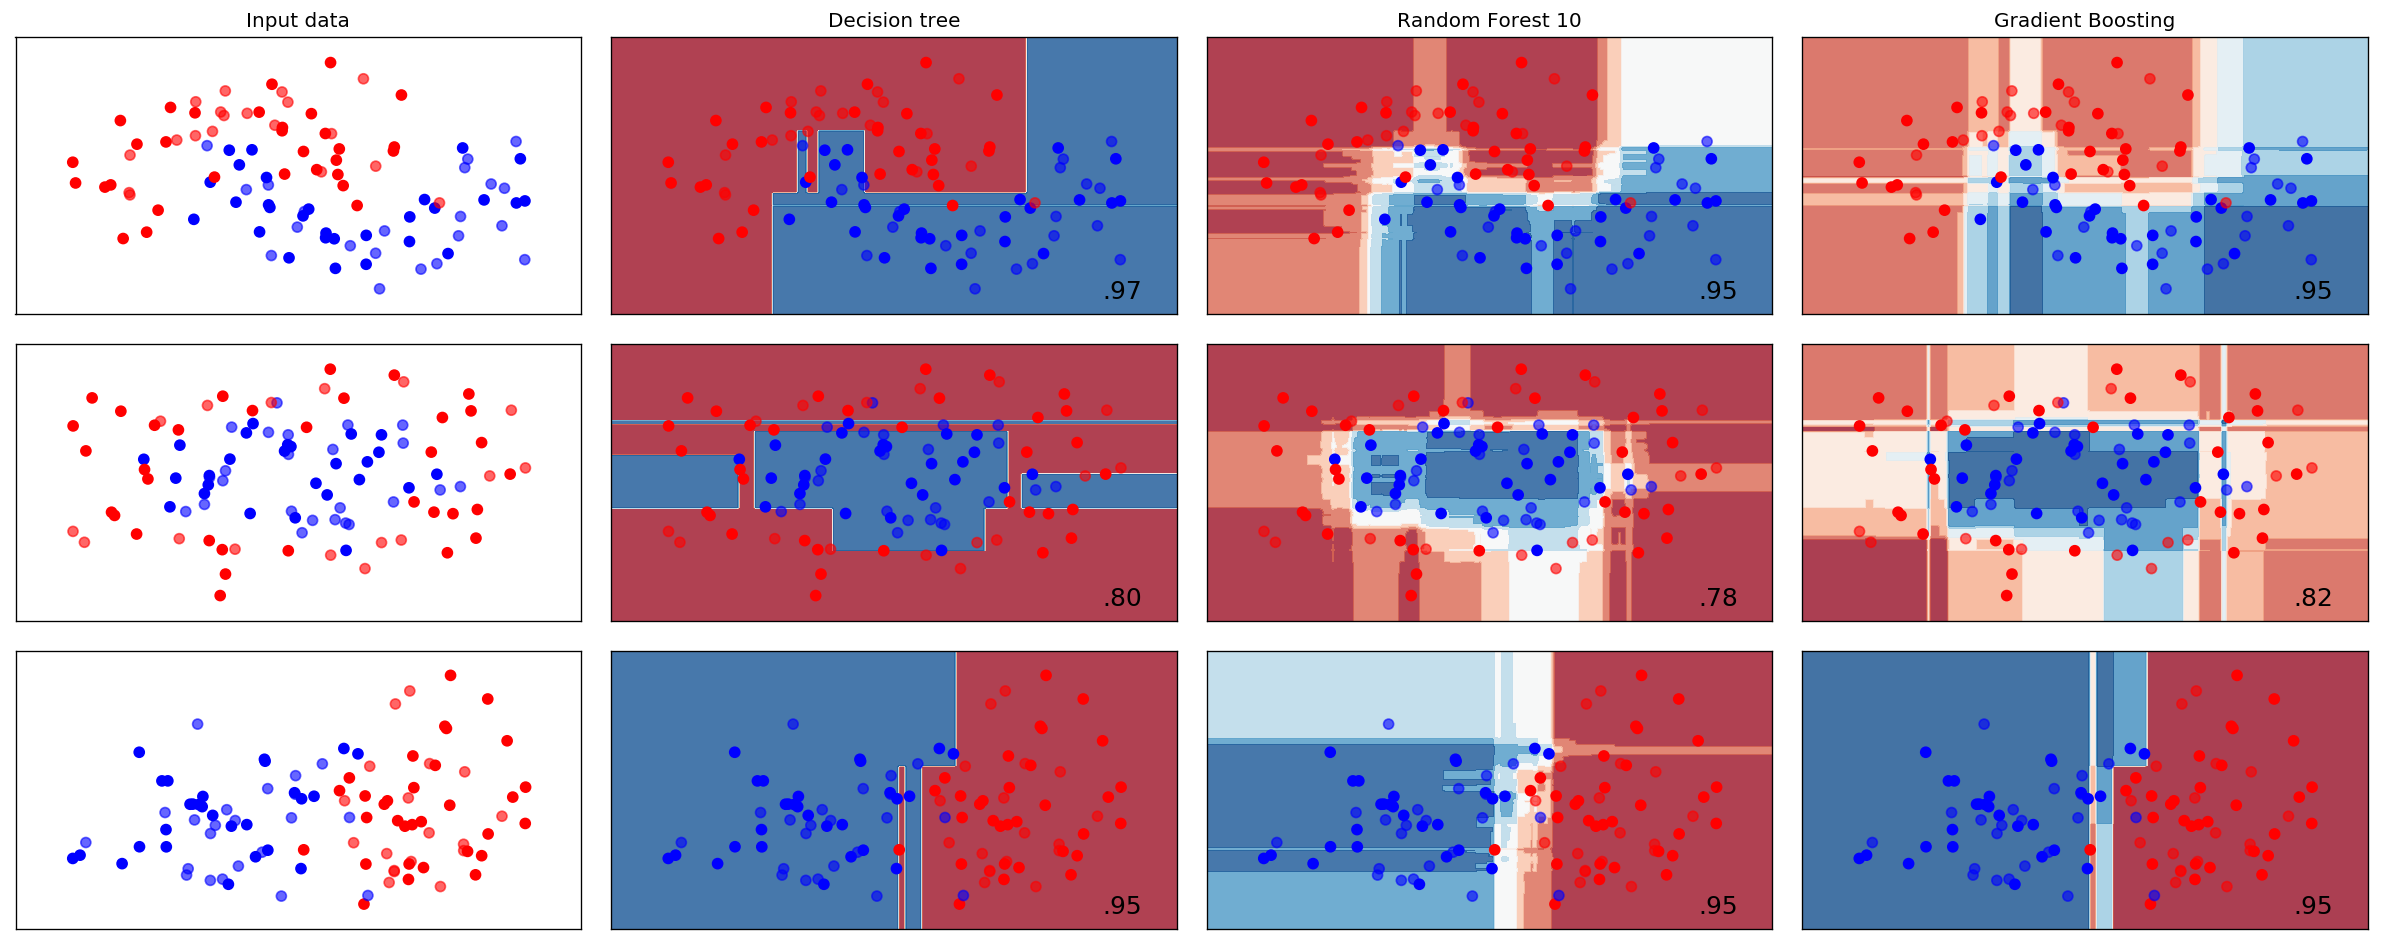

In [97]:
import plot_classifiers as pc
names = ["Decision tree", "Random Forest 10", "Gradient Boosting"]

classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(max_depth=5, n_estimators=100, max_features=1),
    GradientBoostingClassifier(random_state=0, learning_rate=0.5)
    ]

pc.plot_classifiers(names, classifiers, figuresize=(20,8))

### Summary
- Bagging / RandomForest is a variance-reduction technique
    - Build many high-variance (overfitting) models
        - Typically deep (randomized) decision trees
        - The more different the models, the better
    - Aggregation (soft voting or averaging) reduces variance
    - Parallellizes easily
- Boosting is a bias-reduction technique
    - Build many high-bias (underfitting) models
        - Typically shallow decision trees
        - Sample weights are updated to create different trees
    - Aggregation (soft voting or averaging) reduces bias
    - Doesn't parallelize easily
        - Approximation techniques exist to speed up calculation
- You can build ensembles with other models as well
    - Especially if they show high variance or bias
- It is also possible to build _heterogeneous_ ensembles
    - Models from different algorithms
    - Are combined by letting each algorithm predict
    - Often a meta-classifier/regressor is trained on the predictions: Stacking